In [29]:
pip install python-dateutil

Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn=engine.connect()
#engine

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Mea=Base.classes.measurement
Sta=Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
rec_date=session.query(Mea.date).order_by(Mea.date.desc()).first()
print("Recent Date:",rec_date)

Recent Date: ('2017-08-23',)


In [122]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
twel_mon=dt.date(2017,8,23) - dt.timedelta(days=365)
print("12_Months Ago:",twel_mon)

12_Months Ago: 2016-08-23


In [183]:
# Perform a query to retrieve the date and precipitation scores
#session.query(Mea.date, Mea.prcp).all()
#engine.execute("select date,prcp from measurement where date between '2016-08-23' and '2017-08-23'order by date ").fetchall()


In [82]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
date_prcp = pd.read_sql("select date,prcp from measurement where date between '2016-08-23' and '2017-08-23'order by date ",conn,index_col=['date'])

In [85]:
date_prcp.rename(columns={'prcp':'Percipitation'},inplace=True)
date_prcp.index.rename("Date",inplace=True)
#date_prcp.head()
#date_prcp.tail()


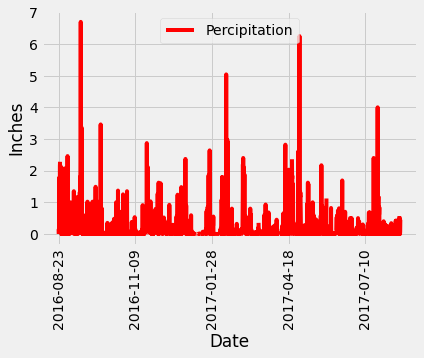

In [178]:
# Use Pandas Plotting with Matplotlib to plot the data
date_prcp.plot(rot=90, color='red')
plt.ylabel('Inches')
plt.legend(fontsize=14)
plt.show()

In [123]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [134]:
# Design a query to calculate the total number stations in the dataset
#engine.execute("select count(station)from station").fetchall()
num_sta=session.query(Sta.station).count()
print(f" The number of Stations in the dataset equals {num_sta}")

 The number of Stations in the dataset equals 9


In [145]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
engine.execute("select id, count (station)as station_activity from measurement group by station order by station_activity DESC").fetchall()
Station_act = pd.read_sql("select station, count (station)as station_activity from measurement group by station order by station_activity DESC",conn)
Station_act

,station,station_activity
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [156]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
engine.execute('SELECT min(tobs) as Lowest, max(tobs) as Highest, round(avg(tobs),2) as Average FROM measurement where station ="USC00519281"').fetchall()
USC00519281_temps=pd.read_sql('SELECT min(tobs) as Lowest, max(tobs) as Highest, round(avg(tobs),2) as Average FROM measurement where station ="USC00519281"',conn)
USC00519281_temps

,Lowest,Highest,Average
0,54.0,85.0,71.66


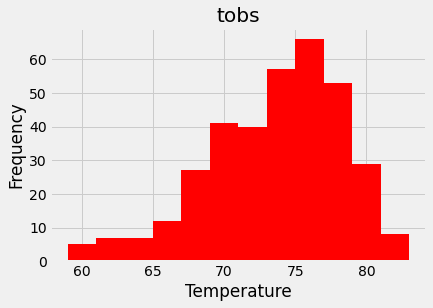

In [181]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_results=pd.read_sql("select date,tobs from measurement where station ='USC00519281' and date between '2016-08-23' and '2017-08-23'order by date",conn,index_col=['date'])
USC00519281_results.index.rename("Date",inplace=True)
#USC00519281_results
USC00519281_results.hist(color='red',bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.show()

# Close session

In [182]:
# Close Session
session.close()